# Learn the noise

## Overview 

Can a Neural Net make predictions about the noise not just the signal?
In other words, can a ML algorithm learn how much it does NOT know?

I think so!

To gain intuition we use the simple example of fitting the (noisy) data and check wheather the ML algorithm can predict both the signal and the noise.

## Setup

Consider a noisy labelled data $(x,y)$. The data is generated by drawing samples from the equation
$$
    y_i= f(x_i) + \eta_i,
$$
where $f(x_i)$ is some fixed, but (possibly unknown) function, and $\eta_i$ is a Gaussian, uncorrelate noise variable such that
$$
\langle \eta_i \rangle=0 \\
\langle \eta_i \eta_j \rangle = \delta_{ij} r^2
$$

The NN architecture is as following:
1. one input unit (containing x_i)
2. one or more hidden layers with a number of hidden units hidden={n1,n2,n3,...}
3. there are two output units. One is predicting the signal $\hat{y}_i$ and has a linear activation function, while the other is predicting the noise $\sigma^2$ and has a Relu activation function.

The proposed loss function is:
$$
\mathcal{Loss}=\sum_i \frac{(y_i-\hat{y}_i)^2}{\sigma^2_i+\epsilon} + \sigma^2_i
$$

where $\epsilon=1E-5$ is a small number used to prevent division by zero. We note that the minimum of the Loss function is obtained for 

$$\hat{y}_i \approx y_i \quad\text{and}\quad \sigma^2_i = (y_i-\hat{y}_i)^2$$

Of course a model will try to overfit the data (i.e. fit the noise as well) to produce $\hat{y}_i = y_i$ and $\sigma^2_i=0$ which is the global minimum of the loss function. However overfitting is easy to identify since leads to the Test error being much larger than the Train error (high variance problem). When the model is optimally trainined (neither overfit not underfit) the the train error and test error should be similar and hopefully the NN will predict $\sigma^2_i \approx r^2$ for ANY $i$.

## Parameters

The parameters of the model are:
1. data generation: range of ${x_i}$, functional form of $f(x_i)=\sin(20*x_i)$, value of the noise $r^2=0, 0.1, 0.5$, dataset size $m$
2. NN architecture: values of $n1,n2,n3,...$
3. hyperparameters: epochs, gradient descent method. 

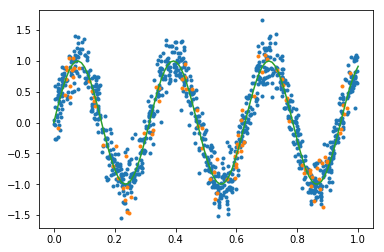

In [2]:
# Generate the data that we are trying to fit

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

def f(x):
    return np.sin(20*x)

N_train=1000 # size of train set
N_test=100   # size of test set
xmin=0 #minimum value of x 
xmax=1 #maximum value of x
r2=0.05 #noise strenght in the data

# Train and Test dataset
np.random.seed(1) # for reproducibility
x_train_raw = xmin + np.random.rand(N_train)*(xmax-xmin)
x_test_raw  = xmin + np.random.rand(N_test)*(xmax-xmin)
y_train_raw = f(x_train_raw)+np.random.randn(N_train)*np.sqrt(r2)
y_test_raw  = f(x_test_raw)+np.random.randn(N_test)*np.sqrt(r2)

# Plotting 
ordered=np.linspace(xmin,xmax,100)
p1=plt.plot(x_train_raw,y_train_raw, "o",ms=3, label='Training')
p2=plt.plot(x_test_raw,y_test_raw, "o",ms=3, label='Test')
p3=plt.plot(ordered,f(ordered),ms=2, label='Exact')

In [3]:
from keras.layers import Input, Dense, Concatenate
from keras.models import Model

# This returns a tensor
inputs = Input(shape=(1,),name='input')

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(40, activation='relu', name='layer1')(inputs)
x = Dense(40, activation='relu', name='layer2')(x)
x = Dense(40, activation='relu', name='layer3')(x)
y_hat = Dense(1, activation='linear', name='yhat')(x)


# Define the model
model = Model(inputs=inputs, outputs=y_hat)
model.summary()

Using Theano backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1)                 0         
_________________________________________________________________
layer1 (Dense)               (None, 40)                80        
_________________________________________________________________
layer2 (Dense)               (None, 40)                1640      
_________________________________________________________________
layer3 (Dense)               (None, 40)                1640      
_________________________________________________________________
yhat (Dense)                 (None, 1)                 41        
Total params: 3,401
Trainable params: 3,401
Non-trainable params: 0
_________________________________________________________________


dict_keys(['loss', 'mean_squared_error'])


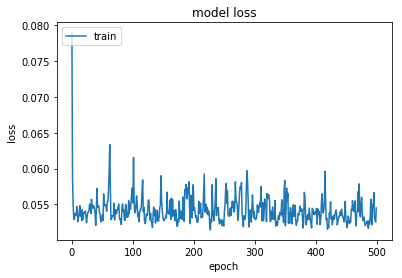

In [9]:
## This is the automatic way
#from keras import metrics
#model.compile(loss='mse', optimizer='adam', metrics=['mse']) 

# This is the custon way
import keras.backend as K
def loss_custom(delta):
    def loss(y_true, y_pred):
        return (K.square(y_true-y_pred))
    return loss

# In any case do the training and plot the loss
model.compile(loss=loss_custom(delta=1), optimizer='adam', metrics=['mse']) 
history=model.fit(x_train_raw,y_train_raw, epochs=500, batch_size=100,verbose=0)
print(history.history.keys())

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

['loss', 'mean_squared_error']
[0.057220506787300111, 0.057220506787300111]
[0.058266700804233552, 0.058266700804233552]


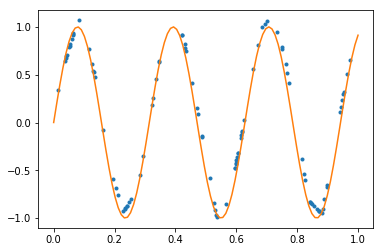

In [10]:
# Evaluate the model

score_train = model.evaluate(x_train_raw,y_train_raw, verbose=0)
score_test = model.evaluate(x_test_raw,y_test_raw, verbose=0)
print(model.metrics_names)
print(score_train)
print(score_test)

y_test_pred = model.predict(x_test_raw, batch_size=1)
test=plt.plot(x_test_raw,y_test_pred, "o",ms=3, label='Test')
test=plt.plot(ordered,f(ordered),ms=2, label='Exact')